In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

import tensorflow as tf
from torch.utils.data import DataLoader, Dataset

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = '../models'
subDir = 'fashion_MNIST'
altName = 'tf_cnn'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
#tf.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results
np.random.seed(RANDOM_STATE)  #setting random state to numpy
tf.random.set_seed(RANDOM_STATE)  #setting random state to tensorflow

EPOCHS = 200 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
#TEST_SIZE = 0.2
PATIENCE = 20
LR_PATIENCE = 10  #normally kept half of patience
LR_FACTOR = 0.1

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (9, 9),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

In [4]:
trainFilepath = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
testFilepath = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(trainFilepath)
test_df = pd.read_csv(testFilepath)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
class_labels = {0 : 'T-shirt/top',
                1  : 'Trouser',
                2  : 'Pullover',
                3 : 'Dress',
                4 : 'Coat',
                5 : 'Sandal',
                6 : 'Shirt',
                7 : 'Sneaker',
                8 : 'Bag',
                9 : 'Ankle boot'}

In [6]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

<Axes: xlabel='label'>

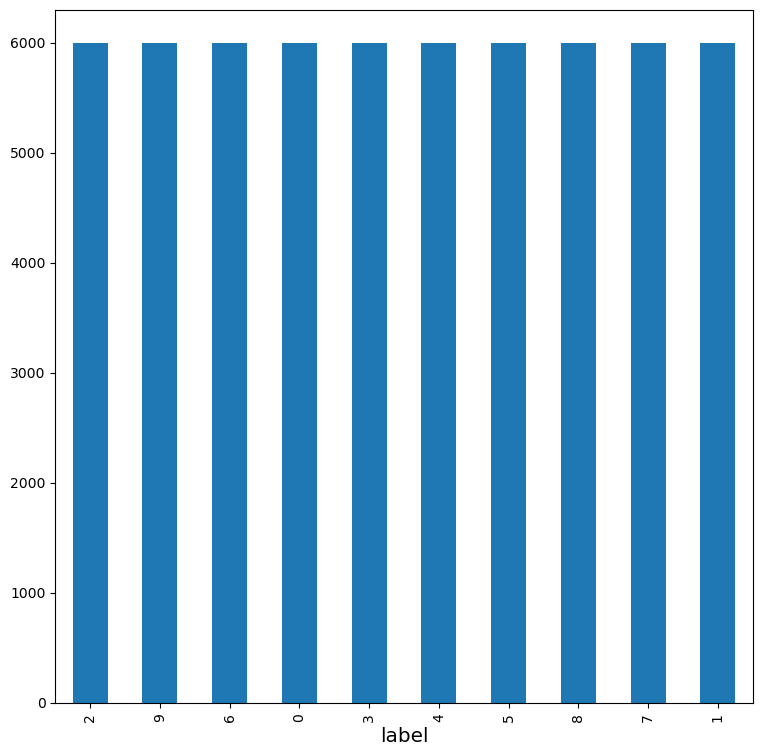

In [7]:
train_df['label'].value_counts().plot(kind='bar')

## Prepare data

In [8]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

In [10]:
def split_feature_label(row):
    feature = tf.reshape(row[1:],[28,28,1])
    label = row[0]
    return feature, label

In [11]:
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(split_feature_label)

train_ds = train_ds.batch(BATCH_SIZE)

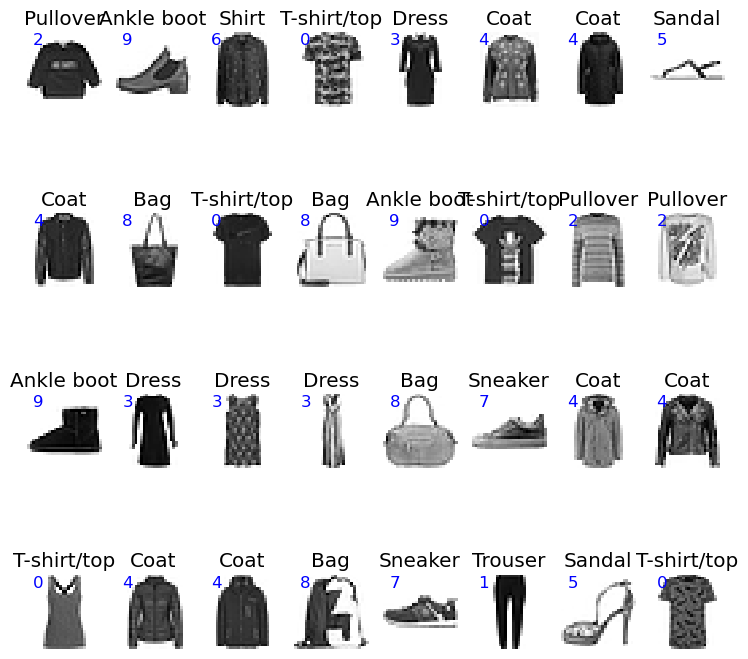

In [12]:
# Sample data plot

for images, labels in train_ds.take(1):

    for i in range(BATCH_SIZE):

        plt.subplot(4, int(BATCH_SIZE//4), i+1)
    
        plt.imshow(images[i].numpy().astype('uint16'),
                   cmap=plt.cm.binary, 
                   interpolation='nearest')   # show image on the axis
    
        plt.title(class_labels[labels[i].numpy()])     # add number (class) of the image
    
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)   # add name of the image

        plt.axis('off')
    
plt.show()

In [13]:
tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(split_feature_label)

test_ds = test_ds.batch(BATCH_SIZE)

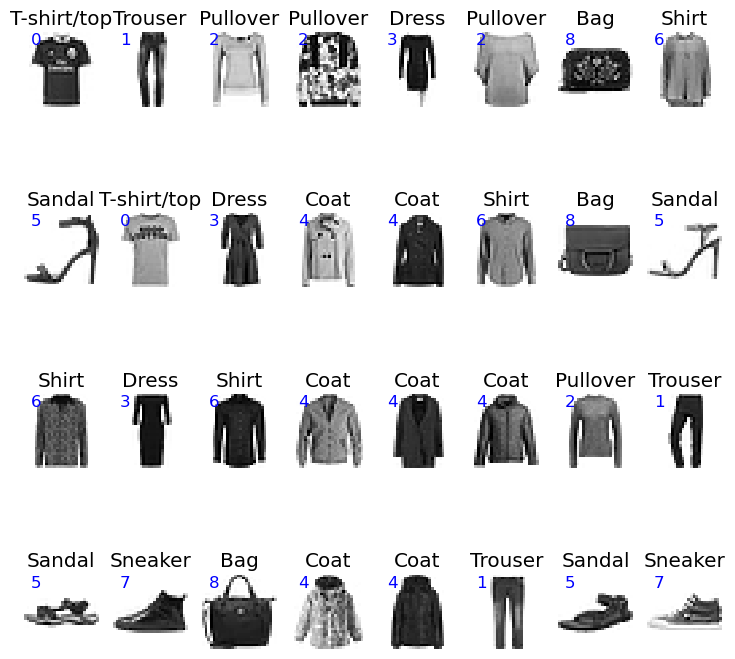

In [14]:
# Sample data plot

for images, labels in test_ds.take(1):

    for i in range(BATCH_SIZE):

        plt.subplot(4, int(BATCH_SIZE//4), i+1)
    
        plt.imshow(images[i].numpy().astype('uint16'),
                   cmap=plt.cm.binary, 
                   interpolation='nearest')   # show image on the axis
    
        plt.title(class_labels[labels[i].numpy()])     # add number (class) of the image
    
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)   # add name of the image

        plt.axis('off')
    
plt.show()

In [15]:
#optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
reg_lambda = 0.005

#knl_reg = tf.keras.regularizers.L2(reg_lambda)
knl_reg = None

#dropout rates
dor1 = 0.2
dor2 = 0.2
dor3 = 0.2
dor4 = 0.2

model = tf.keras.Sequential()


#Preprocessing
model.add(tf.keras.layers.Rescaling(1./255.))

#-------------------------------------------------------------------------------
#Set1
model.add(tf.keras.layers.Conv2D( 32, 3, 
    padding='same',
    activation='relu',
    kernel_regularizer = knl_reg,                             
    input_shape = (28, 28, 1)))           #28 x 28 x 32


model.add(tf.keras.layers.Dropout(dor1))
#Max pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2))) # 14 X 14 X 32



#-------------------------------------------------------------------------------
#Set2
model.add(tf.keras.layers.Conv2D( 64, 3, 
    activation='relu',
    kernel_regularizer = knl_reg))           #12 x 12 x 64
model.add(tf.keras.layers.Dropout(dor2))

#Max pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2))) # 6 X 6 X 64



#-------------------------------------------------------------------------------
#Set3
model.add(tf.keras.layers.Conv2D( 128, 3, 
    activation='relu',
    kernel_regularizer = knl_reg))           #4 x 4 x 128

model.add(tf.keras.layers.Dropout(dor3))

## Head

In [17]:
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer = knl_reg))

model.add(tf.keras.layers.Dropout(dor4))

model.add(tf.keras.layers.Dense(10))

In [18]:
model.compile(optimizer='adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
checkpoint_path = os.path.join(modelDir, subDir, 'CNN')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True)

es_checkpoint = tf.keras.callbacks.EarlyStopping( #early stopping call back, after some time 
    monitor='val_loss',                           #if there is no change in loss then assume it is only your good weights
    patience=PATIENCE,
    mode='auto',
    restore_best_weights=True
)

lr_checkpoint = tf.keras.callbacks.ReduceLROnPlateau(   #learning rate call back used for decreasing learning rate, when loss is not improving
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_lr=0.00001
)

In [20]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks = [model_checkpoint, es_checkpoint, lr_checkpoint],
                    verbose=2)

Epoch 1/200



Epoch 1: val_loss improved from inf to 0.34844, saving model to ../models\fashion_MNIST\CNN
1875/1875 - 35s - loss: 0.5085 - accuracy: 0.8164 - val_loss: 0.3484 - val_accuracy: 0.8794 - lr: 0.0010 - 35s/epoch - 19ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.34844 to 0.29661, saving model to ../models\fashion_MNIST\CNN
1875/1875 - 32s - loss: 0.3330 - accuracy: 0.8800 - val_loss: 0.2966 - val_accuracy: 0.8873 - lr: 0.0010 - 32s/epoch - 17ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.29661 to 0.25350, saving model to ../models\fashion_MNIST\CNN
1875/1875 - 31s - loss: 0.2863 - accuracy: 0.8955 - val_loss: 0.2535 - val_accuracy: 0.9097 - lr: 0.0010 - 31s/epoch - 17ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.25350 to 0.24278, saving model to ../models\fashion_MNIST\CNN
1875/1875 - 32s - loss: 0.2595 - accuracy: 0.9039 - val_loss: 0.2428 - val_accuracy: 0.9116 - lr: 0.0010 - 32s/epoch - 17ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.242

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                        

In [22]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.508462,0.816400,0.348438,0.8794,0.001
1,0.333000,0.880033,0.296608,0.8873,0.001
2,0.286335,0.895517,0.253500,0.9097,0.001
3,0.259467,0.903900,0.242776,0.9116,0.001
4,0.238827,0.911500,0.218913,0.9199,0.001


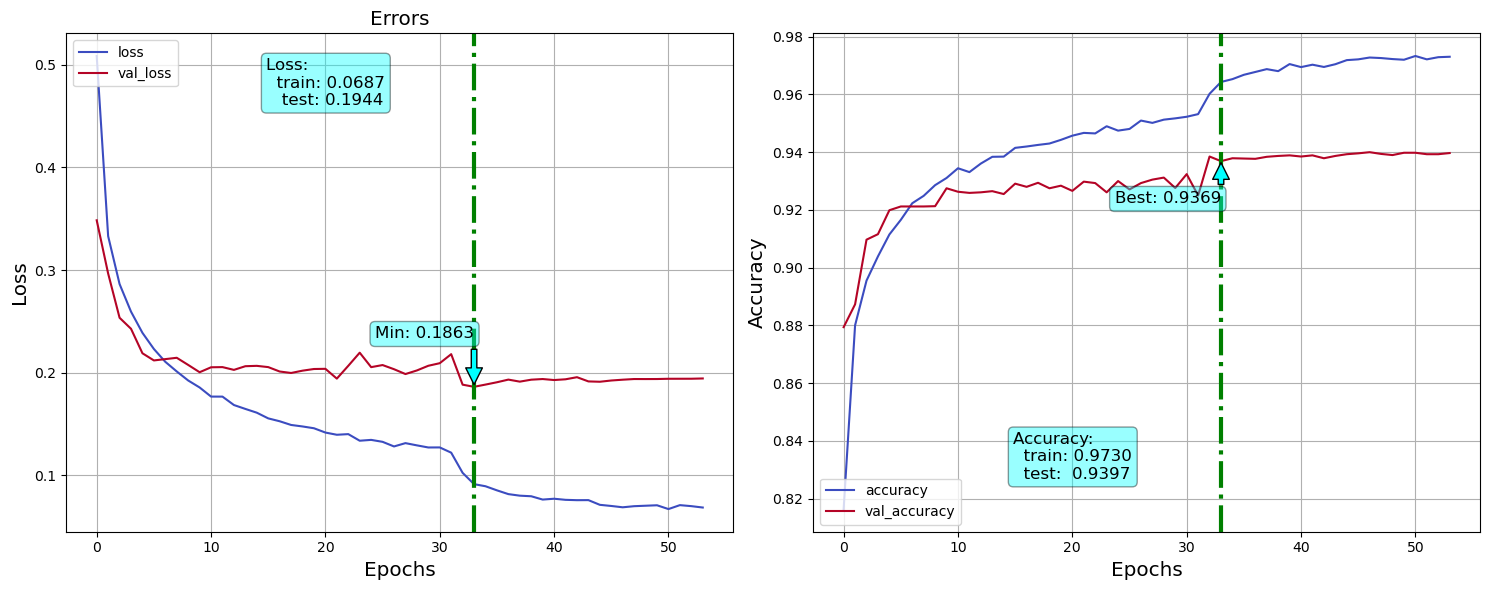

In [23]:
fn_plot_tf_hist(loss_df)